In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile
zip_path = "/content/drive/MyDrive/cifar10_images.zip"
extract_path = "/content/cifar10_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,TensorDataset
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR

In [ ]:
import os
print(os.listdir("/content/drive/MyDrive"))

['Colab Notebooks', 'Classroom', 'IMG_20220921_201745.jpg', 'IMG_20220921_201739.jpg', 'IMG_20220921_201536.jpg', 'IMG_20220921_201534.jpg', 'IMG_20220921_200557.jpg', 'IMG_20220921_200358.jpg', 'IMG_20220921_200346.jpg', 'IMG_20220921_200344.jpg', 'IMG_20220921_200335.jpg', 'IMG_20220921_200045.jpg', 'IMG_20210331_233030.jpg', 'IMG_20210109_192758 (1).jpg', 'IMG_20210112_200952 (1).JPG', 'IMG_20210112_200814 (1).JPG', 'IMG_20210112_200803 (1).JPG', 'IMG_20210109_111510 (2).jpg', 'IMG_20210109_111459.jpg', 'IMG_20210112_200831 (1).JPG', 'IMG_20210109_111436 (1).jpg', 'IMG_20210109_111426 (1).jpg', 'IMG_20210112_200924 (1).JPG', 'IMG_20210112_200901 (1).JPG', 'IMG_20210109_111408_1 (1).jpg', 'IMG_20210109_111408 (1).jpg', 'IMG_20210112_200938 (1).JPG', 'IMG_20210109_111304 (1).jpg', 'IMG_20210109_111256 (1).jpg', 'IMG_20210108_113115.jpg', 'IMG_20210108_113112.jpg', 'IMG_20210105_103242.jpg', 'IMG_20210105_103219.jpg', 'IMG_20210118_110842.jpg', 'IMG_20210109_192807 (1).jpg', 'IMG_20210

In [ ]:
transform = transforms.Compose([
    transforms.Resize(96),  # Resize images to at least 96x96
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomCrop(96, padding=4),  # Crop and resize the image to 96x96 (after resizing)
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

test_transform = transforms.Compose([
    transforms.Resize(96),  # Resize test images to 96x96
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize test images
])

train_dataset = ImageFolder(root="/content/cifar10_images/cifar10_images/train", transform=transform)
test_dataset = ImageFolder(root="/content/cifar10_images/cifar10_images/test", transform=test_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

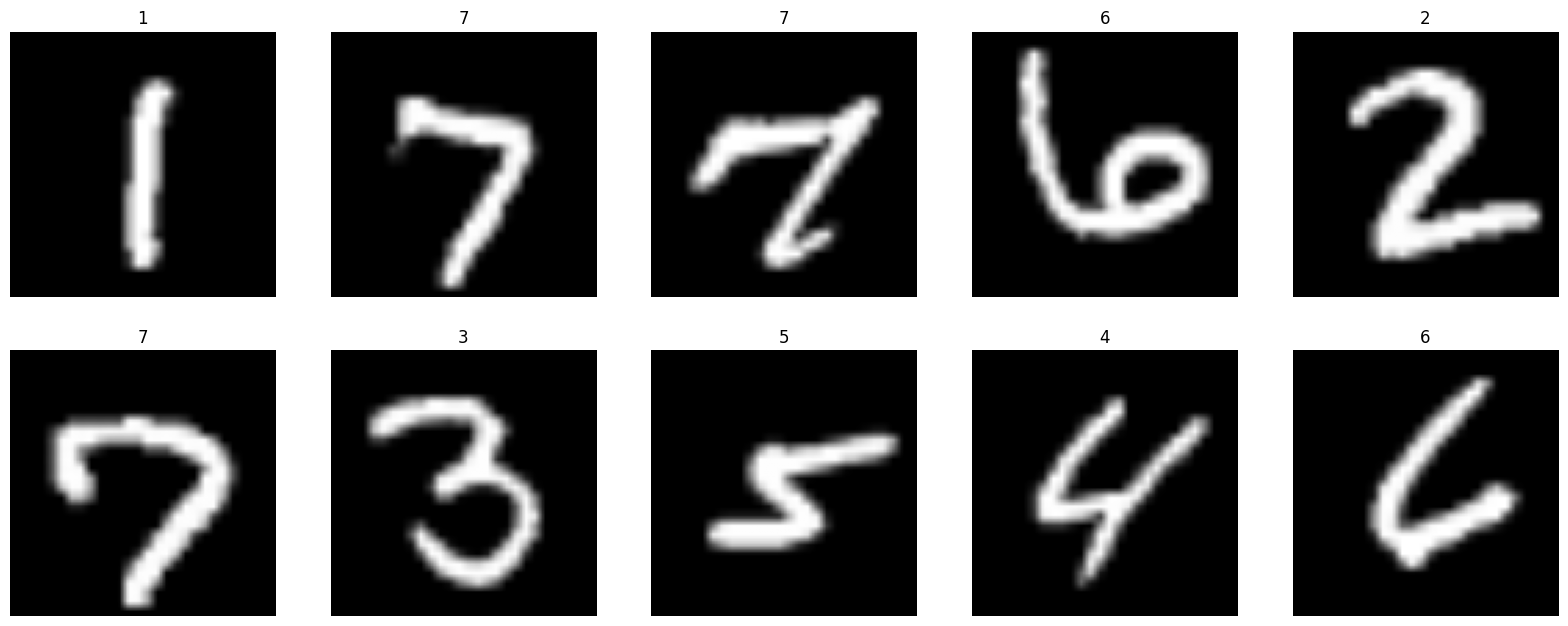

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(10):
    image, label = test_dataset[random.randint(0, len(test_dataset) - 1)]
    plt.subplot(5, 5, i + 1)
    # Since MNIST images are single-channel, we remove the channel dimension for display
    plt.imshow(image.squeeze(0), cmap='gray')  # Use cmap='gray' for grayscale images
    plt.title(train_dataset.classes[label])
    plt.axis("off")

In [ ]:
class Patch_Linear_Embedding(nn.Module):
    def __init__(self, patch_size=4, embedding_dim=96):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim

        self.proj = nn.Linear(patch_size * patch_size * 3, embedding_dim)


    def forward(self, x):
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5)
        x = x.reshape(x.shape[0] ,x.shape[1],x.shape[2] , self.patch_size * self.patch_size * 3)
        x = self.proj(x)
        return x


In [ ]:
class W_MSA(nn.Module):
    def __init__(self, dim, window_size=6, num_heads=8):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.proj = nn.Linear(dim, dim)
    def forward(self, x):
        """
        x: (B, H, W, D)
        """
        B, H, W, D = x.shape
        ws = self.window_size
        x = x.reshape(B, H // ws, ws, W // ws, ws, D)
        x = x.permute(0, 1, 3, 2, 4, 5)
        x = x.reshape(-1, ws * ws, D)


        M, V, C = x.shape  # [total, ws * ws, dim]
        qkv = self.qkv(x)  # [total, ws * ws, 3 * dim]
        qkv = qkv.reshape(M, V, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, total, heads, ws * ws, head_dim]

        q, k, v = qkv[0], qkv[1], qkv[2]  # each: [total, heads, ws * ws, head_dim]

        # Attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # [total, heads, ws * ws, ws * ws]
        attn = torch.softmax(scores, dim=-1)

        # Weighted sum of values
        out = torch.matmul(attn, v)  # [total, heads, ws * ws, head_dim]
        out = out.permute(0, 2, 1, 3).reshape(M, V, C)  # [total, ws * ws, dim]

        # Reverse the window partitioning
        out = out.reshape(B, H // ws, W // ws, ws, ws, D)  # [B, H//ws, W//ws, ws, ws, D]
        out = out.permute(0, 1, 3, 2, 4, 5)  # [B, H//ws, W//ws, D, ws, ws]
        out = out.reshape(B, H, W, D)  # [B, H, W, D] - Reconstructed
        return out


In [ ]:
def mask(B, H, W,ss,ws):
    mask = torch.zeros(B, H, W, dtype=torch.int)
    mask[:, :ss, :ss] = 0
    mask[:, :ss, ss:] = 1
    mask[:, ss:, :ss] = 2
    mask[:, ss:, ss:] = 3
    shift_size = ss
    shifted_mask = torch.roll(mask, shifts=(-shift_size, -shift_size), dims=(1, 2))
    shifted_mask = shifted_mask.reshape(B, H // ws, ws, W // ws, ws)
    shifted_mask = shifted_mask.permute(0, 1, 3, 2, 4)
    shifted_mask = shifted_mask.reshape(-1, ws * ws)
    N, L = shifted_mask.shape
    eq = shifted_mask.unsqueeze(2) == shifted_mask.unsqueeze(1)
    attn_mask = torch.where(eq, torch.tensor(0.0), torch.tensor(float('-inf')))
    return attn_mask

In [ ]:
class SW_MSA(nn.Module):
    def __init__(self, dim, window_size=6, shift_size=3, num_heads=8):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        """
        x: (B, H, W, D)
        """
        B, H, W, D = x.shape
        ws = self.window_size
        ss = self.shift_size
        x = torch.roll(x, shifts=(-ss, -ss), dims=(1, 2))


        attn_mask = mask(B, H, W, ss, ws)
        attn_mask = mask(B, H, W, ss, ws).to(x.device)



        x = x.reshape(B, H // ws, ws, W // ws, ws, D)
        x = x.permute(0, 1, 3, 2, 4, 5)
        x = x.reshape(-1, ws * ws, D)

        M, V, C = x.shape  # [total, ws * ws, dim]
        qkv = self.qkv(x)  # [total, ws * ws, 3 * dim]
        qkv = qkv.reshape(M, V, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, total, heads, ws * ws, head_dim]

        q, k, v = qkv[0], qkv[1], qkv[2]  # each: [total, heads, ws * ws, head_dim]

        # Attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # [total, heads, ws * ws, ws * ws]
        scores = scores + attn_mask.unsqueeze(1)
        attn = torch.softmax(scores, dim=-1)
        # Weighted sum of values
        out = torch.matmul(attn, v)# [total, heads, ws * ws, head_dim]
        out = out.permute(0, 2, 1, 3).reshape(M, V, C)

        # Reverse the window partitioning
        out = out.reshape(B, H // ws, W // ws, ws, ws, D)
        out = out.permute(0, 1, 3, 2, 4, 5)
        out = out.reshape(B, H, W, D)
        out = torch.roll(out, shifts=(ss, ss), dims=(1, 2))
        out = self.proj(out)
        return out

In [ ]:
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads = 8, window_size=6, shift_size=3):
        super().__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.norm1 = nn.LayerNorm(dim)
        self.attn1 = W_MSA(dim, num_heads=num_heads, window_size=window_size)

        self.norm2 = nn.LayerNorm(dim)
        self.norm3 = nn.LayerNorm(dim)
        self.norm4 = nn.LayerNorm(dim)
        self.mlp1 = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        self.attn2 = SW_MSA(dim, num_heads=num_heads, window_size=window_size, shift_size=shift_size)


        self.mlp2 = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )



    def forward(self, x):
        B, H, W, C = x.shape

        x = x + self.attn1(self.norm1(x))
        x = x + self.mlp1(self.norm2(x))
        x = x + self.attn2(self.norm3(x))
        x = x + self.mlp2(self.norm4(x))
        return x

In [ ]:
class PatchMerging(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.reduction = nn.Linear(4 * input_dim, 2 * input_dim, bias=False)
        self.norm = nn.LayerNorm(4 * input_dim)

    def forward(self, x):
        B, H, W, C = x.shape

        # Step 1: reshape 2x2 patches into one
        x0 = x[:, 0::2, 0::2, :]  # top-left
        x1 = x[:, 0::2, 1::2, :]  # top-right
        x2 = x[:, 1::2, 0::2, :]  # bottom-left
        x3 = x[:, 1::2, 1::2, :]  # bottom-right
        # Step 2: concatenate along the channel dimension
        x_merged = torch.cat([x0, x1, x2, x3], dim=-1)  # Shape: [B, H/2, W/2, 4C]
        # Step 3: normalization and linear projection to reduce dim
        x_merged = self.norm(x_merged)
        x_merged = self.reduction(x_merged)  # Shape: [B, H/2, W/2, 2C]
        return x_merged



In [ ]:
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim=384, num_classes=10):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # pools HxW to 1x1
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x shape: [B, H, W, C] → convert to [B, C, H, W]
        x = x.permute(0, 3, 1, 2)
        x = self.avg_pool(x)           # [B, C, 1, 1]
        x = x.reshape(x.size(0), -1)      # [B, Cx1x1]
        return self.fc(x)              # [B, num_classes]


In [ ]:
class SimpleSwinTransformer(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.embedding = Patch_Linear_Embedding(patch_size=4, embedding_dim=96)
        self.stb1 = SwinTransformerBlock(dim=96, window_size=6, shift_size=3, num_heads=8)
        self.stb2 = SwinTransformerBlock(dim=96, window_size=6, shift_size=3, num_heads=8)
        self.stb3 = SwinTransformerBlock(dim=192, window_size=6, shift_size=3, num_heads=8)
        self.stb4 = SwinTransformerBlock(dim=192, window_size=6, shift_size=3, num_heads=8)
        self.stb5 = W_MSA(dim = 384, window_size=6, num_heads=8)
        self.stb6 = W_MSA(dim = 384, window_size=6, num_heads=8)
        self.patch_merging1 = PatchMerging(input_dim=96)
        self.patch_merging2 = PatchMerging(input_dim=192)
        self.classification_head = ClassificationHead(embed_dim=384, num_classes=num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.stb1(x)
        x = self.stb2(x)
        x = self.patch_merging1(x)
        x = self.stb3(x)
        x = self.stb4(x)
        x = self.patch_merging2(x)
        x = self.stb5(x)
        x = self.stb6(x)
        x = self.classification_head(x)
        return x



In [ ]:
# Warm-up function to increase the learning rate gradually
def warmup_lr(epoch, warmup_epochs, initial_lr=1e-3):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs * initial_lr  # Linear warmup
    return initial_lr

# Learning rate scheduler for warm-up and cosine annealing
def get_scheduler(epoch, warmup_scheduler, cosine_scheduler, warmup_epochs):
    if epoch < warmup_epochs:
        warmup_scheduler.step(epoch)
    else:
        cosine_scheduler.step()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleSwinTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# Number of warm-up epochs and total training epochs
warmup_epochs = 5
total_epochs = 50
T_max = total_epochs - warmup_epochs  # Total number of epochs for Cosine Annealing after warmup

# Warm-up scheduler
warmup_scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: warmup_lr(epoch, warmup_epochs))

# Cosine annealing scheduler
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=1e-6)


In [ ]:
# Training function
def train(model, loader, optimizer, criterion, epoch, warmup_scheduler, cosine_scheduler, warmup_epochs):
    model.train()
    total_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for imgs, labels in tqdm(loader, desc=f"Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)     # [B, 10]
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Train Loss: {avg_loss:.4f}")

    # Update learning rate after each epoch
    get_scheduler(epoch, warmup_scheduler, cosine_scheduler, warmup_epochs)

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")

In [ ]:
#  Training loop
for epoch in range(1, total_epochs + 1):
    # Train for one epoch
    train(model, train_loader, optimizer, criterion, epoch, warmup_scheduler, cosine_scheduler, warmup_epochs)

    # Evaluate the model on the test set
    evaluate(model, test_loader)

    # Save model after each epoch (optional)
    model_save_path = f"/content/drive/MyDrive/simple_swin_epoch{epoch}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

Epoch 1: 100%|██████████| 938/938 [02:37<00:00,  5.94it/s]

Train Loss: 2.2974



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test Accuracy: 13.08%
Model saved to /content/drive/MyDrive/simple_swin_epoch1.pth


Epoch 2: 100%|██████████| 938/938 [02:47<00:00,  5.59it/s]

Train Loss: 2.2683


Test Accuracy: 20.75%
Model saved to /content/drive/MyDrive/simple_swin_epoch2.pth


Epoch 3: 100%|██████████| 938/938 [02:48<00:00,  5.56it/s]

Train Loss: 2.1059


Test Accuracy: 28.66%
Model saved to /content/drive/MyDrive/simple_swin_epoch3.pth


Epoch 4: 100%|██████████| 938/938 [02:48<00:00,  5.57it/s]

Train Loss: 1.9065


Test Accuracy: 35.37%
Model saved to /content/drive/MyDrive/simple_swin_epoch4.pth


Epoch 5: 100%|██████████| 938/938 [02:48<00:00,  5.57it/s]

Train Loss: 1.7673


Test Accuracy: 42.49%
Model saved to /content/drive/MyDrive/simple_swin_epoch5.pth


Epoch 6: 100%|██████████| 938/938 [02:48<00:00,  5.58it/s]

Train Loss: 1.6567


Test Accuracy: 48.32%
Model saved to /content/drive/MyDrive/simple_swin_epoch6.pth


Epoch 7: 100%|██████████| 938/938 [02:48<00:00,  5.56it/s]

Train Loss: 1.5452


Test Accuracy: 56.64%
Model saved to /content/drive/MyDrive/simple_swin_epoch7.pth


Epoch 8: 100%|██████████| 938/938 [02:48<00:00,  5.57it/s]

Train Loss: 1.3841


Test Accuracy: 65.96%
Model saved to /content/drive/MyDrive/simple_swin_epoch8.pth


Epoch 9: 100%|██████████| 938/938 [02:47<00:00,  5.59it/s]

Train Loss: 1.1881


Test Accuracy: 70.40%
Model saved to /content/drive/MyDrive/simple_swin_epoch9.pth


Epoch 10: 100%|██████████| 938/938 [02:47<00:00,  5.60it/s]

Train Loss: 1.0179


Test Accuracy: 74.11%
Model saved to /content/drive/MyDrive/simple_swin_epoch10.pth


Epoch 11: 100%|██████████| 938/938 [02:47<00:00,  5.59it/s]

Train Loss: 0.8961


Test Accuracy: 76.07%
Model saved to /content/drive/MyDrive/simple_swin_epoch11.pth


Epoch 12: 100%|██████████| 938/938 [02:47<00:00,  5.59it/s]

Train Loss: 0.8135


Test Accuracy: 77.83%
Model saved to /content/drive/MyDrive/simple_swin_epoch12.pth


Epoch 13: 100%|██████████| 938/938 [02:47<00:00,  5.59it/s]

Train Loss: 0.7493


Test Accuracy: 80.74%
Model saved to /content/drive/MyDrive/simple_swin_epoch13.pth


Epoch 14: 100%|██████████| 938/938 [02:47<00:00,  5.60it/s]

Train Loss: 0.7012


Test Accuracy: 81.59%
Model saved to /content/drive/MyDrive/simple_swin_epoch14.pth


Epoch 15: 100%|██████████| 938/938 [02:49<00:00,  5.55it/s]

Train Loss: 0.6545


Test Accuracy: 82.66%
Model saved to /content/drive/MyDrive/simple_swin_epoch15.pth


Epoch 16: 100%|██████████| 938/938 [02:48<00:00,  5.58it/s]

Train Loss: 0.6200


Test Accuracy: 83.54%
Model saved to /content/drive/MyDrive/simple_swin_epoch16.pth


Epoch 17: 100%|██████████| 938/938 [02:48<00:00,  5.57it/s]

Train Loss: 0.5864


Test Accuracy: 84.72%
Model saved to /content/drive/MyDrive/simple_swin_epoch17.pth


Epoch 18: 100%|██████████| 938/938 [02:47<00:00,  5.59it/s]

Train Loss: 0.5627


Test Accuracy: 86.05%
Model saved to /content/drive/MyDrive/simple_swin_epoch18.pth


Epoch 19: 100%|██████████| 938/938 [02:47<00:00,  5.60it/s]

Train Loss: 0.5340


Test Accuracy: 86.66%
Model saved to /content/drive/MyDrive/simple_swin_epoch19.pth


Epoch 20: 100%|██████████| 938/938 [02:47<00:00,  5.59it/s]

Train Loss: 0.5173


Test Accuracy: 87.03%
Model saved to /content/drive/MyDrive/simple_swin_epoch20.pth


Epoch 21: 100%|██████████| 938/938 [02:47<00:00,  5.61it/s]

Train Loss: 0.4949


Test Accuracy: 87.50%
Model saved to /content/drive/MyDrive/simple_swin_epoch21.pth


Epoch 22: 100%|██████████| 938/938 [02:47<00:00,  5.61it/s]

Train Loss: 0.4791


Test Accuracy: 88.06%
Model saved to /content/drive/MyDrive/simple_swin_epoch22.pth


Epoch 23: 100%|██████████| 938/938 [02:47<00:00,  5.59it/s]

Train Loss: 0.4644


Test Accuracy: 88.56%
Model saved to /content/drive/MyDrive/simple_swin_epoch23.pth


Epoch 24: 100%|██████████| 938/938 [02:47<00:00,  5.59it/s]

Train Loss: 0.4466


Test Accuracy: 89.18%
Model saved to /content/drive/MyDrive/simple_swin_epoch24.pth


Epoch 25: 100%|██████████| 938/938 [02:48<00:00,  5.57it/s]

Train Loss: 0.4345


Test Accuracy: 89.40%
Model saved to /content/drive/MyDrive/simple_swin_epoch25.pth


Epoch 26: 100%|██████████| 938/938 [02:48<00:00,  5.56it/s]

Train Loss: 0.4167


Test Accuracy: 90.23%
Model saved to /content/drive/MyDrive/simple_swin_epoch26.pth


Epoch 27: 100%|██████████| 938/938 [02:47<00:00,  5.59it/s]

Train Loss: 0.4090


Test Accuracy: 90.07%
Model saved to /content/drive/MyDrive/simple_swin_epoch27.pth


Epoch 28: 100%|██████████| 938/938 [02:47<00:00,  5.59it/s]

Train Loss: 0.3948


Test Accuracy: 90.59%
Model saved to /content/drive/MyDrive/simple_swin_epoch28.pth


Epoch 29: 100%|██████████| 938/938 [02:47<00:00,  5.59it/s]

Train Loss: 0.3827


Test Accuracy: 91.12%
Model saved to /content/drive/MyDrive/simple_swin_epoch29.pth


Epoch 30: 100%|██████████| 938/938 [02:48<00:00,  5.58it/s]

Train Loss: 0.3731


Test Accuracy: 91.14%
Model saved to /content/drive/MyDrive/simple_swin_epoch30.pth


Epoch 31:   4%|▎         | 35/938 [00:06<02:41,  5.58it/s]


KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleSwinTransformer().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/simple_swin_epoch10.pth"))
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
all_labels = []
all_preds = []
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

    # Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, output_dict=True)

    # Save metrics to text file
with open(f"/content/drive/MyDrive/metric2.txt", 'w') as f:
    f.write("Accuracy: {:.2f}%\n".format(accuracy * 100))
    f.write("Precision: {:.2f}\n".format(precision))
    f.write("Recall: {:.2f}\n".format(recall))
    f.write("F1 Score: {:.2f}\n".format(f1))
    f.write("\nConfusion Matrix:\n")
    f.write(np.array2string(cm))
    f.write("\n\nClassification Report:\n")
    for label, metrics in report.items():
        f.write(f"Label {label}: {metrics}\n")

    # Save confusion matrix plot
    plt.figure(figsize=(10, 8))
    classes = [str(i) for i in range(10)]  # for MNIST
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/confusion_matrix_metric2.png")
    plt.close()

In [ ]:
import os
os.listdir("/content/drive/MyDrive/cifar")

['simple_swin_epoch28.pth',
 'simple_swin_epoch14.pth',
 'simple_swin_epoch16.pth',
 'simple_swin_epoch2.pth',
 'simple_swin_epoch19.pth',
 'simple_swin_epoch23.pth',
 'simple_swin_epoch25.pth',
 'simple_swin_epoch13.pth',
 'simple_swin_epoch11.pth',
 'simple_swin_epoch17.pth',
 'simple_swin_epoch6.pth',
 'simple_swin_epoch1.pth',
 'simple_swin_epoch18.pth',
 'simple_swin_epoch8.pth',
 'simple_swin_epoch4.pth',
 'simple_swin_epoch22.pth',
 'simple_swin_epoch7.pth',
 'simple_swin_epoch5.pth',
 'simple_swin_epoch20.pth',
 'simple_swin_epoch21.pth',
 'simple_swin_epoch3.pth',
 'simple_swin_epoch15.pth',
 'simple_swin_epoch9.pth',
 'simple_swin_epoch27.pth',
 'simple_swin_epoch26.pth',
 'simple_swin_epoch10.pth',
 'simple_swin_epoch12.pth',
 'simple_swin_epoch24.pth']

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

def epoch_vs_accuracy(device):
    accuracy_test = []
    accuracy_train = []

    for i in tqdm(range(1, 29), desc="Evaluating Epochs"):
        # Load model
        swin = SimpleSwinTransformer(num_classes=10).to(device)
        checkpoint_path = f'/content/drive/MyDrive/cifar/simple_swin_epoch{i}.pth'
        swin.load_state_dict(torch.load(checkpoint_path, map_location=device))
        swin.eval()

        # --- Test Accuracy ---
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = swin(images)
                _, predicted = outputs.max(1)
                correct_test += predicted.eq(labels).sum().item()
                total_test += labels.size(0)
        acc_test = 100 * correct_test / total_test
        accuracy_test.append(acc_test)

        # --- Train Accuracy ---
        correct_train = 0
        total_train = 0
        with torch.no_grad():
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = swin(images)
                _, predicted = outputs.max(1)
                correct_train += predicted.eq(labels).sum().item()
                total_train += labels.size(0)
        acc_train = 100 * correct_train / total_train
        accuracy_train.append(acc_train)

        # Print progress
        print(f"Epoch {i}: Train Acc = {acc_train:.2f}%, Test Acc = {acc_test:.2f}%")

    # --- Plot ---
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 31), accuracy_train, label='Train Accuracy')
    plt.plot(range(1, 31), accuracy_test, label='Test Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Epoch vs Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save to Google Drive
    plt.savefig("/content/drive/MyDrive/epoch_vs_accuracy.png")
    plt.close()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epoch_vs_accuracy(device)

Evaluating Epochs:   0%|          | 0/28 [00:00<?, ?it/s]


NameError: name 'SimpleSwinTransformer' is not defined